# **Load Data**

In [1]:
!gdown --id 1OlcvGWReJMuyYQuOZm149vHWwPtlboR6 --output train.csv
!gdown --id 1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w --output valid.csv
!gdown --id 1ep9H6-HvhB4utJRLVcLzieWNUSG3P_uF --output test.csv

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1OlcvGWReJMuyYQuOZm149vHWwPtlboR6
To: /content/train.csv
100% 799k/799k [00:00<00:00, 25.5MB/s]
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w
To: /content/valid.csv
100% 43.3k/43.3k [00:00<00:00, 36.4MB/s]
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ep9H

# **Import Packages**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras import layers


# **Read Data**

In [3]:
train = pd.read_csv("/content/train.csv")
valid = pd.read_csv("/content/valid.csv")
test = pd.read_csv("/content/test.csv")

In [4]:
train.head()

,text,intent
0,listen to westbam alumb allergic on google music,PlayMusic
1,add step to me to the 50 clásicos playlist,AddToPlaylist
2,i give this current textbook a rating value of...,RateBook
3,play the song little robin redbreast,PlayMusic
4,please add iris dement to my playlist this is ...,AddToPlaylist


In [5]:
train.shape


(13084, 2)

In [6]:
valid.shape


(700, 2)

In [7]:
test.shape

(700, 2)

In [8]:
train['intent'].value_counts()

PlayMusic               1914
GetWeather              1896
BookRestaurant          1881
RateBook                1876
SearchScreeningEvent    1852
SearchCreativeWork      1847
AddToPlaylist           1818
Name: intent, dtype: int64

# **Plot Intents**

[Text(0, 0, '0'),
 Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(3, 0, '3'),
 Text(4, 0, '4'),
 Text(5, 0, '5'),
 Text(6, 0, '6')]

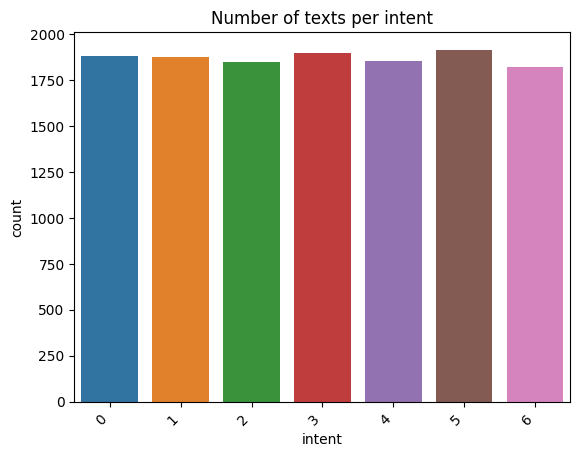

In [55]:
#Plot intents
chart = sns.countplot(x=train['intent'])
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, ha="right")


# **Feature Engineering**

In [10]:
tokenizer=Tokenizer()

tokenizer.fit_on_texts(train['text'].values)

In [11]:
word_index = tokenizer.word_index
vocab_size=len(word_index)

print(vocab_size)

11086


In [12]:
train_sequences = tokenizer.texts_to_sequences(train['text'].values)
sen_len=[]
for i in train_sequences:
    sen_len.append(len(i))

In [13]:
max(sen_len)

35

In [14]:
train_padded = pad_sequences(train_sequences, maxlen=40, padding='post')

In [15]:
valid_sequences = tokenizer.texts_to_sequences(valid['text'].values)

valid_padded = pad_sequences(valid_sequences, maxlen=40, padding='post')

In [31]:
classes=list(set(list(train['intent'].values)))

class_index={}

c=0
for i in classes:
    class_index[i]=c
    c+=1

for i in range(train.shape[0]):
    train['intent'].loc[i]=class_index[train['intent'].loc[i]]

y_train=tf.keras.utils.to_categorical(train['intent'].values, num_classes=7, dtype='float32')

for i in range(valid.shape[0]):
    valid['intent'].loc[i]=class_index[valid['intent'].loc[i]]

y_valid=tf.keras.utils.to_categorical(valid['intent'].values, num_classes=7, dtype='float32')

In [17]:
y_train.shape

(13084, 7)

In [18]:
y_valid.shape

(700, 7)

# **Model Training**

In [30]:
tf.keras.backend.clear_session()  

embedding_dim = 64 

def create_func_model():
    inputs = tf.keras.Input(shape=(40,))
    o1 = layers.Embedding(vocab_size+1,embedding_dim )(inputs)
    o2=tf.keras.layers.LSTM(64,return_sequences=True, return_state=True)(o1)
    o3=tf.keras.layers.LSTM(64)(o2)
    o4 = layers.Dense(128, activation='relu')(o3)
    outputs = layers.Dense(7,activation='softmax')(o4)

    model_func = tf.keras.Model(inputs, outputs, name='model_func')

  
    model_func.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
    return model_func

In [20]:
model=create_func_model()

In [21]:
model.summary()

Model: "model_func"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 64)       709568      ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 40, 64),     33024       ['embedding[0][0]']              
                                 (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                         

In [22]:
model.fit(train_padded,y_train,epochs=10,validation_data=(valid_padded,y_valid))

Epoch 1/10
409/409 [==============================] - 38s 80ms/step - loss: 1.0509 - accuracy: 0.5233 - val_loss: 0.5067 - val_accuracy: 0.7843
Epoch 2/10
409/409 [==============================] - 35s 86ms/step - loss: 0.5095 - accuracy: 0.7757 - val_loss: 0.3599 - val_accuracy: 0.8800
Epoch 3/10
409/409 [==============================] - 37s 90ms/step - loss: 0.2077 - accuracy: 0.9418 - val_loss: 0.1918 - val_accuracy: 0.9543
Epoch 4/10
409/409 [==============================] - 36s 88ms/step - loss: 0.0819 - accuracy: 0.9795 - val_loss: 0.1731 - val_accuracy: 0.9614
Epoch 5/10
409/409 [==============================] - 32s 79ms/step - loss: 0.0454 - accuracy: 0.9892 - val_loss: 0.1611 - val_accuracy: 0.9700
Epoch 6/10
409/409 [==============================] - 33s 81ms/step - loss: 0.0352 - accuracy: 0.9921 - val_loss: 0.1452 - val_accuracy: 0.9700
Epoch 7/10
409/409 [==============================] - 36s 87ms/step - loss: 0.0469 - accuracy: 0.9891 - val_loss: 0.1137 - val_accuracy:

In [23]:
for i in range(test.shape[0]):
    test['intent'].loc[i]=class_index[test['intent'].loc[i]]

y_test=tf.keras.utils.to_categorical(test['intent'].values, num_classes=7, dtype='float32')

In [24]:
test_sequences = tokenizer.texts_to_sequences(test['text'].values)

test_padded = pad_sequences(test_sequences, maxlen=40, padding='post')

# **Prediction**

In [25]:
y_pred=model.predict(test_padded)

22/22 [==============================] - 1s 18ms/step


In [26]:
pred=np.argmax(y_pred,axis=1)
actual=np.argmax(y_test,axis=1)

In [36]:
con_mat = tf.math.confusion_matrix(labels=actual, predictions=pred).numpy()

In [46]:
pd.set_option('display.max_columns', None)
class_names=classes

con_mat_dataframe = pd.DataFrame(con_mat,index = class_names, columns = class_names)
print(con_mat_dataframe)

    0   1   2    3   4   5    6
0  90   0   0    1   0   0    1
1   0  80   0    0   0   0    0
2   0   0  98    0   5   4    0
3   3   0   0  101   0   0    0
4   0   0  13    0  94   0    0
5   0   0   6    0   0  79    1
6   0   0   0    1   0   0  123


In [45]:
total=0
for i in range(pred.shape[0]):
    if pred[i]==actual[i]:
        total+=1
print('accuracy of test data '+str(total/700))



accuracy of test data 0.95
